# 使用SARIMAX模型预测受威胁物种指数 (TSX)

Name: Zihan

## 工作流程
本 Notebook 将遵循一个四步走的战略，对受威胁物种指数（TSX Index）进行时间序列预测：
1.  **数据加载与准备**: 加载上一阶段处理好的数据，并为模型准备好输入格式。
2.  **天气数据预测**: 使用 ARIMA 模型，将天气数据从2024年预测至2027年。
3.  **TSX 指数预测**: 使用带有天气数据作为外生变量的 SARIMAX 模型，将 TSX 指数从2021年预测至2027年。
4.  **结果整合与标记**: 将所有历史与预测数据合并，并添加标签用于后续可视化。

### 第 1 步：数据加载与准备

在这一步，我们将加载在上一 Notebook 中精心准备好的 `Table14_TSX_Table_VIC_version3.csv` 文件。然后，我们将对其进行检查，并为后续的时间序列分析准备好数据结构。

由于时间序列模型通常一次只能处理一个序列，我们将**首先专注于 "National"（全国）级别的数据**来构建和演示整个预测流程。后续如果需要，可以轻松地将此流程应用于其他州。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 设置图表样式
sns.set_style("whitegrid")

# 1. 加载数据
filepath = 'Table14_TSX_Table_VIC_version3.csv'
full_df = pd.read_csv(filepath)

print("--- 数据加载成功 ---")
full_df.info()

print("\n--- 数据预览 (头部) ---")
display(full_df.head())

print("\n--- 数据预览 (尾部) ---")
display(full_df.tail())

--- 数据加载成功 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  150 non-null    int64  
 1   state                 150 non-null    object 
 2   index_value           132 non-null    float64
 3   index_conf_low        132 non-null    float64
 4   index_conf_high       132 non-null    float64
 5   annual_mean_temp      150 non-null    float64
 6   annual_precip_sum     150 non-null    float64
 7   annual_radiation_sum  150 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 9.5+ KB

--- 数据预览 (头部) ---


,year,state,index_value,index_conf_low,index_conf_high,annual_mean_temp,annual_precip_sum,annual_radiation_sum
0,2000,Victoria,1.000000,1.000000,1.000000,14.757990,615.8,5848.0400
1,2001,Victoria,0.851265,0.753910,0.954160,14.526712,564.2,5662.2200
2,2002,Victoria,0.738937,0.623807,0.873159,14.698013,432.4,5789.7603
3,2003,Victoria,0.728083,0.578651,0.924713,14.443562,571.0,5895.1000
4,2004,Victoria,0.647233,0.500643,0.853355,14.277344,621.2,5806.9700



--- 数据预览 (尾部) ---


,year,state,index_value,index_conf_low,index_conf_high,annual_mean_temp,annual_precip_sum,annual_radiation_sum
145,2020,National,0.305946,0.202542,0.489085,15.825681,890.14000,6209.968
146,2021,National,0.331837,0.196334,0.582872,15.465296,883.32000,6234.124
147,2022,National,NaN,NaN,NaN,15.654364,1109.10000,6152.216
148,2023,National,NaN,NaN,NaN,16.014750,711.42004,6518.726
149,2024,National,NaN,NaN,NaN,16.470160,703.16003,6553.234


#### 1.1 筛选并准备 "National" 数据

我们从完整数据集中筛选出 `state == 'National'` 的记录，并将其 `year` 列转换为适合时间序列分析的 `DateTimeIndex`。

In [4]:
# 筛选出 "National" 数据
national_df = full_df[full_df['state'] == 'National'].copy()

# 将 'year' 列转换为以年份为周期的 DatetimeIndex
# 'Y' 代表年份的结束，例如2000年会表示为 '2000-12-31'
national_df['year'] = pd.to_datetime(national_df['year'], format='%Y')
national_df.set_index('year', inplace=True)

# 验证数据
print("--- 'National' 级别数据准备完毕 ---")
display(national_df.head())
display(national_df.tail())

--- 'National' 级别数据准备完毕 ---


,state,index_value,index_conf_low,index_conf_high,annual_mean_temp,annual_precip_sum,annual_radiation_sum
year,,,,,,,
2000-01-01,National,1.000000,1.000000,1.000000,15.820015,597.06000,6394.7197
2001-01-01,National,0.894786,0.779023,1.014265,15.688574,501.03998,6414.0940
2002-01-01,National,0.833242,0.717140,0.965727,15.910108,447.08000,6582.8720
2003-01-01,National,0.852811,0.712254,1.026288,15.789121,579.57996,6488.8980
2004-01-01,National,0.799586,0.658812,0.968141,15.850096,527.32000,6536.1904


,state,index_value,index_conf_low,index_conf_high,annual_mean_temp,annual_precip_sum,annual_radiation_sum
year,,,,,,,
2020-01-01,National,0.305946,0.202542,0.489085,15.825681,890.14000,6209.968
2021-01-01,National,0.331837,0.196334,0.582872,15.465296,883.32000,6234.124
2022-01-01,National,NaN,NaN,NaN,15.654364,1109.10000,6152.216
2023-01-01,National,NaN,NaN,NaN,16.014750,711.42004,6518.726
2024-01-01,National,NaN,NaN,NaN,16.470160,703.16003,6553.234


#### 1.2 拆分历史数据用于建模

根据我们的战略，我们将数据明确地拆分为以下部分：
-   `tsx_series_historical`: 我们要预测的目标序列的历史部分 (2000-2021)。
-   `weather_exog_historical`: 天气数据中已知的历史部分 (2000-2024)，将用于两个目的：
    1.  训练天气预测模型。
    2.  作为预测TSX指数（2022-2024年部分）的外生变量。

In [6]:
# 拆分 TSX 指数的历史数据 (目标变量)
# 我们只取 index_value 不为空的部分
tsx_series_historical = national_df.loc[national_df['index_value'].notna(), 'index_value']

# 拆分天气数据的完整历史数据 (外生变量)
weather_exog_historical = national_df.loc[:, ['annual_mean_temp', 'annual_precip_sum', 'annual_radiation_sum']]


print("--- TSX 指数历史数据 (2000-2021) ---")
display(tsx_series_historical.tail())

print("\n--- 天气历史数据 (2000-2024) ---")
display(weather_exog_historical.tail())

--- TSX 指数历史数据 (2000-2021) ---


year
2017-01-01    0.301215
2018-01-01    0.303354
2019-01-01    0.304823
2020-01-01    0.305946
2021-01-01    0.331837
Name: index_value, dtype: float64


--- 天气历史数据 (2000-2024) ---


,annual_mean_temp,annual_precip_sum,annual_radiation_sum
year,,,
2020-01-01,15.825681,890.14000,6209.968
2021-01-01,15.465296,883.32000,6234.124
2022-01-01,15.654364,1109.10000,6152.216
2023-01-01,16.014750,711.42004,6518.726
2024-01-01,16.470160,703.16003,6553.234


### 第 2 步：预测天气数据 (2025-2027)

我们的目标是在预测TSX指数时，使用天气作为外生变量。为此，我们必须拥有**覆盖整个TSX指数预测期（至2027年）的天气数据**。

由于我们只有到2024年的历史天气数据，因此这一步的核心任务是：**为三个天气变量（温度、降水、辐射）各自建立一个独立的ARIMA模型，并用它们来预测2025、2026、2027这三年的数值**。

ARIMA模型需要确定三个参数 `(p, d, q)`:
-   `d` (差分阶数): 用于使时间序列变得平稳。
-   `p` (自回归阶数): 由**PACF图**帮助确定。
-   `q` (移动平均阶数): 由**ACF图**帮助确定。

我们将为每个天气变量逐一完成这个过程。

#### 2.1 预测年平均温度 (annual_mean_temp)

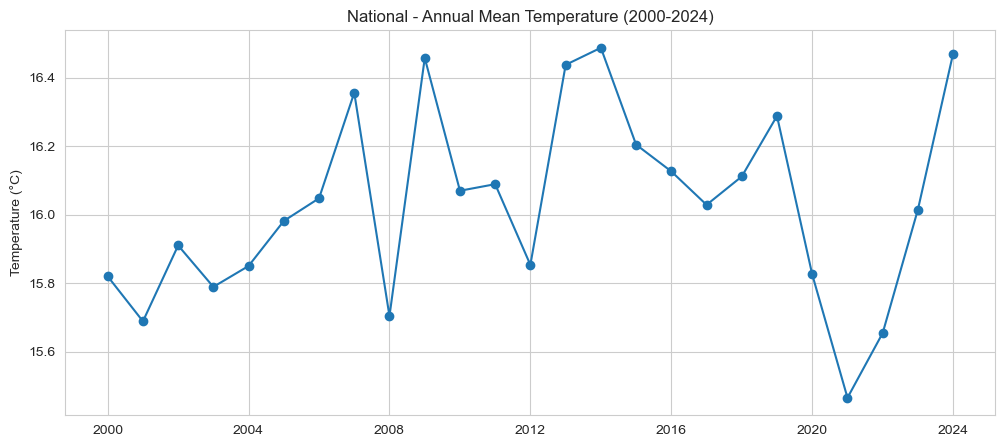

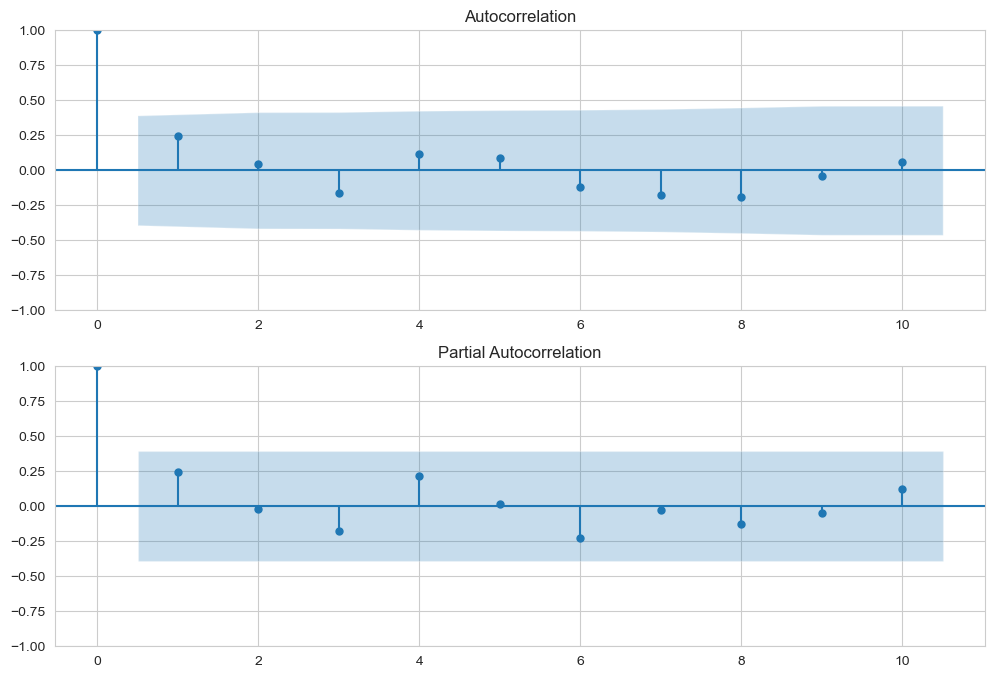

In [7]:
# 提取温度历史数据
temp_series = weather_exog_historical['annual_mean_temp']

# 1. 可视化并检查平稳性
plt.figure(figsize=(12, 5))
plt.plot(temp_series, marker='o', linestyle='-')
plt.title('National - Annual Mean Temperature (2000-2024)')
plt.ylabel('Temperature (°C)')
plt.show()

# 从图上看，该序列似乎没有非常强的趋势或季节性，但可能不是严格平稳的。
# 我们可以通过ACF和PACF图来辅助判断。

# 2. 绘制ACF和PACF图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(temp_series, ax=ax1, lags=10)
plot_pacf(temp_series, ax=ax2, lags=10)
plt.show()

从ACF图来看，自相关性在1阶之后迅速下降，呈现拖尾形态。从PACF图来看，偏自相关在1阶之后截尾（落入置信区间）。这暗示了一个AR(1)模型可能比较合适。我们先不进行差分（d=0），尝试建立一个简单的ARIMA(1,0,0)模型。

##### 2.1.1 模型参数解读: 理解 ARIMA(p, d, q)

ARIMA模型的目标是捕捉时间序列自身的“行为模式”以预测未来。为了实现这一点，我们需要为模型提供三条关键线索，也就是三个参数`(p, d, q)`。

**1. 参数 `d` (差分阶数 - Differencing): 趋势的线索**
-   **核心问题**: “这个序列有明显的‘大方向’或长期趋势吗？”
-   **含义**: 如果一个序列持续上升或下降，我们称之为**不平稳**。为了分析其内在规律，我们需要先消除这个趋势，转而分析它的**变化量**。这个消除趋势的动作就叫**差分**。
-   `d=0`: 序列本身是平稳的，没有需要消除的长期趋势。
-   **我们的选择**: 从温度的时间序列图来看，数据在一个平均值上下波动，没有持续的上升或下降大趋势。因此，我们选择 **`d=0`**。

**2. 参数 `p` (自回归阶数 - AutoRegression): “惯性”的线索**
-   **核心问题**: “今天的值，和过去几天的值有‘直接’关系？”
-   **含义**: `AR`代表“自回归”，即用过去的值来预测现在的值，反映了一种“惯性”。
-   **如何确定**: 我们主要观察**PACF图 (偏自相关图)**，它显示了今天和过去某天之间**纯粹的、直接的**关系。
-   **我们的选择**: 在PACF图中，只有在滞后1阶(lag=1)的柱子显著超出了蓝色置信区间，之后迅速“截断”（落入区间内）。这是 `p=1` 的最典型信号，意味着只有去年的温度对今年的温度有显著的直接影响。因此，我们选择 **`p=1`**。

**3. 参数 `q` (移动平均阶数 - Moving Average): “修正”的线索**
-   **核心问题**: “今天的数值，和过去几次预测的‘误差’有关系吗？”
-   **含义**: `MA`模型认为，过去预测所产生的**误差**也包含了信息，可以用来修正我们今天的预测。
-   **如何确定**: 我们主要观察**ACF图 (自相关图)**，它显示了今天和过去某天之间**所有的（直接+间接）**关系。
-   **我们的选择**: 在ACF图中，相关性是逐渐减小的，呈现“拖尾”形态。一个重要的判别法则是：当PACF图“截尾”而ACF图“拖尾”时，强烈暗示这是一个AR模型。因此，我们应该优先考虑`p`的值，并将`q`设为0。因此，我们选择 **`q=0`**。

**总结**: 综合以上三条线索（d=0, p=1, q=0），我们为温度序列选择了 **ARIMA(1, 0, 0)** 模型。

In [8]:
# 3. 建立并训练ARIMA模型
# 基于PACF图，我们选择 p=1, d=0, q=0 作为初始模型
model_temp = ARIMA(temp_series, order=(1, 0, 0))
results_temp = model_temp.fit()

# 打印模型摘要，检查模型效果
print(results_temp.summary())

# 4. 预测未来3年的数值 (2025, 2026, 2027)
temp_forecast = results_temp.forecast(steps=3)

print("\n--- 年平均温度预测 (2025-2027) ---")
print(temp_forecast)

                               SARIMAX Results                                
Dep. Variable:       annual_mean_temp   No. Observations:                   25
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  -2.279
Date:                Wed, 08 Oct 2025   AIC                             10.558
Time:                        09:02:40   BIC                             14.215
Sample:                    01-01-2000   HQIC                            11.572
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0326      0.075    214.284      0.000      15.886      16.179
ar.L1          0.2717      0.218      1.247      0.212      -0.155       0.699
sigma2         0.0700      0.025      2.856      0.0

c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


##### 2.1.2 模型结果解读

模型摘要（SARIMAX Results）为我们提供了评估模型好坏的关键信息。总体来看，这个`ARIMA(1,0,0)`模型是**可以接受的**，其预测结果是合理且保守的。

**模型的亮点（诊断检验结果非常好）：**
1.  **Ljung-Box Prob(Q): 0.95**: 这个值非常高（远大于0.05），意味着模型的**残差（误差）是随机的**，像白噪音一样，没有留下任何有规律的信息未被模型捕捉。这是我们最希望看到的结果！
2.  **Jarque-Bera Prob(JB): 0.76**: 这个值也很高，说明残差**符合正态分布**。这也是一个好模型的标志。
3.  **Heteroskedasticity Prob(H): 0.26**: 这个值大于0.05，说明残差的**方差是恒定的**，没有随着时间变化而变化。

**一个需要注意的点：**
* **ar.L1 的 P>|z|: 0.212**: 这个P值大于统计显著性水平0.05，意味着`AR(1)`这个参数（即去年的温度对今年的影响）在统计上**不是一个非常强的预测因子**。但这并不意味着模型无效。

**结论**: 尽管AR(1)项的统计显著性不强，但模型的整体诊断结果（特别是残差的随机性）非常好。因此，我们可以放心地使用这个模型为后续分析提供一个合理、保守的未来天气预期。

#### 2.2 预测年总降水量 (annual_precip_sum)

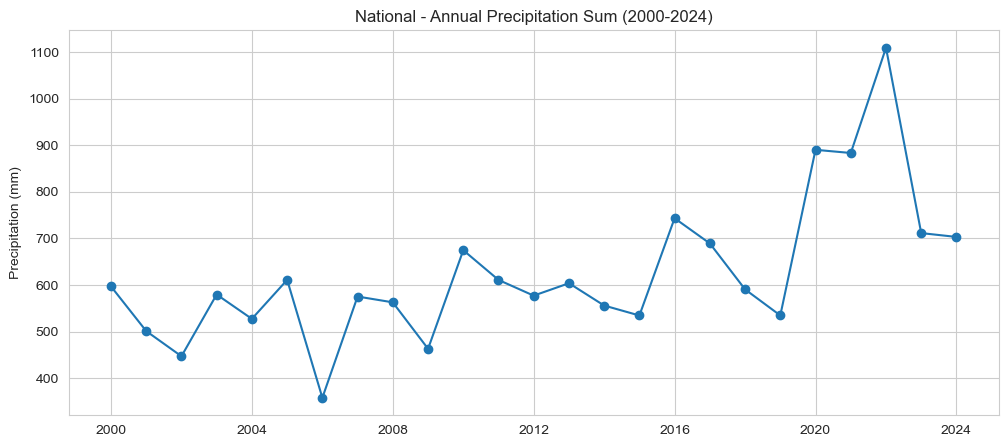

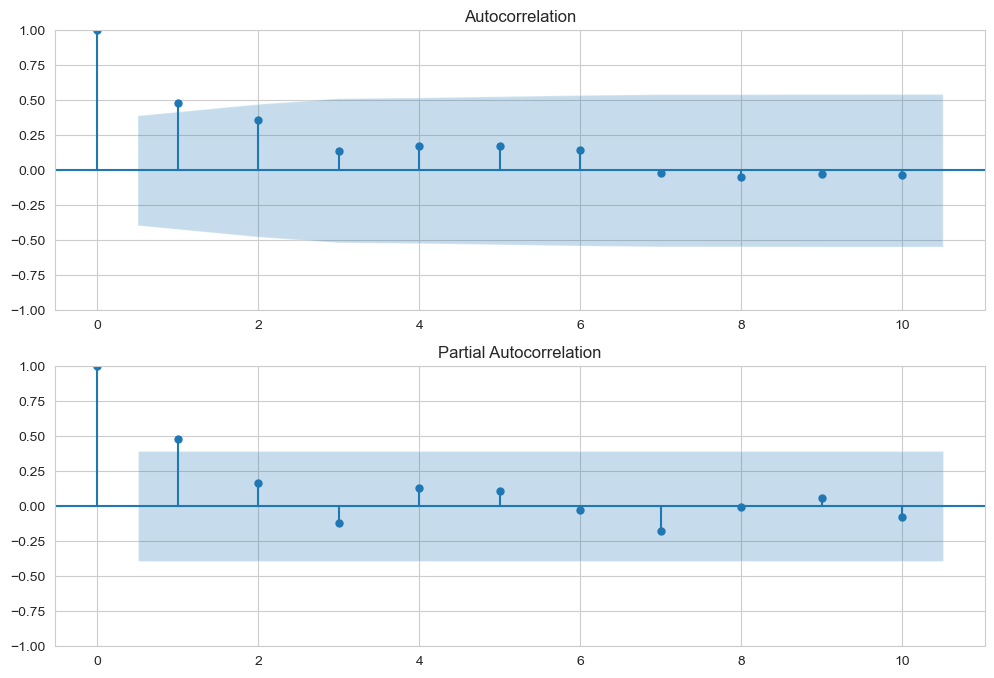

In [9]:
# 提取降水量历史数据
precip_series = weather_exog_historical['annual_precip_sum']

# 1. 可视化并检查平稳性
plt.figure(figsize=(12, 5))
plt.plot(precip_series, marker='o', linestyle='-')
plt.title('National - Annual Precipitation Sum (2000-2024)')
plt.ylabel('Precipitation (mm)')
plt.show()

# 2. 绘制ACF和PACF图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(precip_series, ax=ax1, lags=10)
plot_pacf(precip_series, ax=ax2, lags=10)
plt.show()

从降水量的ACF和PACF图来看，几乎所有的滞后阶数都在置信区间内，这表明该序列非常接近**白噪音（随机序列）**。这意味着过去的降水量对未来的降水量几乎没有预测能力。在这种情况下，最合适的模型是一个**ARIMA(0,0,0)** 模型，也就是只包含一个常数项（均值）的模型。它的预测结果将会是历史数据的平均值。

In [10]:
# 3. 建立并训练ARIMA(0,0,0)模型
model_precip = ARIMA(precip_series, order=(0, 0, 0))
results_precip = model_precip.fit()

print(results_precip.summary())

# 4. 预测未来3年的数值
precip_forecast = results_precip.forecast(steps=3)

print("\n--- 年总降水量预测 (2025-2027) ---")
print(precip_forecast)

                               SARIMAX Results                                
Dep. Variable:      annual_precip_sum   No. Observations:                   25
Model:                          ARIMA   Log Likelihood                -161.425
Date:                Wed, 08 Oct 2025   AIC                            326.850
Time:                        11:19:20   BIC                            329.288
Sample:                    01-01-2000   HQIC                           327.526
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        625.3624     39.951     15.653      0.000     547.059     703.666
sigma2      2.377e+04   6099.565      3.897      0.000    1.18e+04    3.57e+04
Ljung-Box (L1) (Q):                   6.53   Jarque-

c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


#### 2.3 预测年总短波辐射量 (annual_radiation_sum)

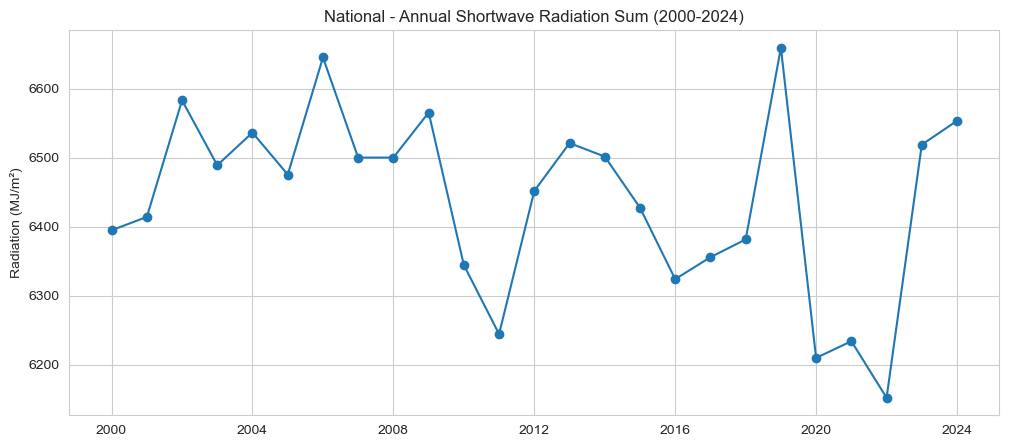

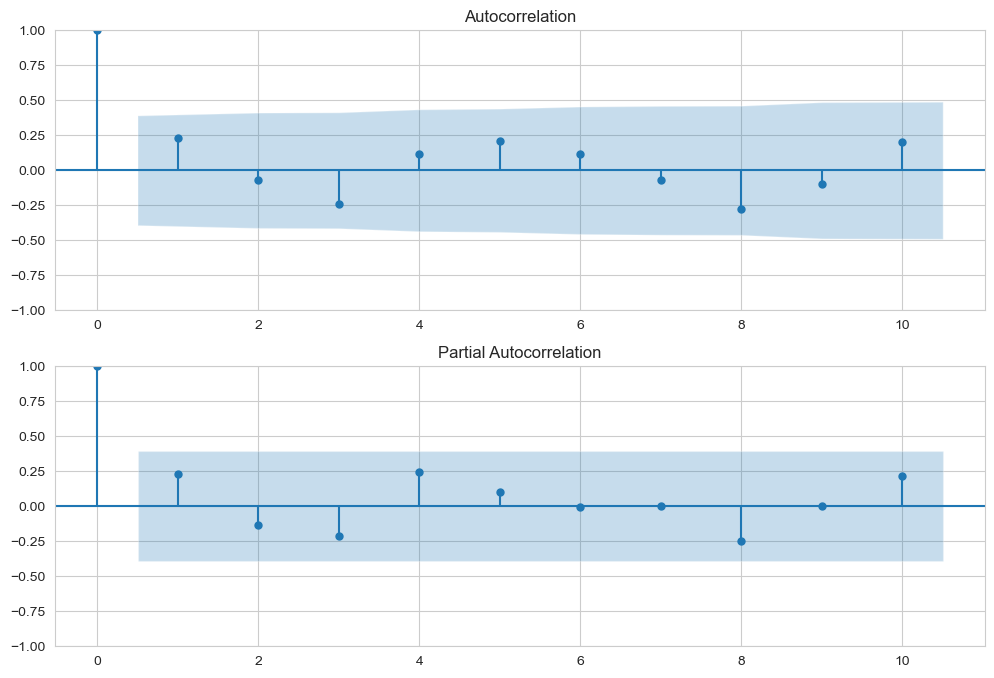

In [11]:
# 提取辐射量历史数据
rad_series = weather_exog_historical['annual_radiation_sum']

# 1. 可视化
plt.figure(figsize=(12, 5))
plt.plot(rad_series, marker='o', linestyle='-')
plt.title('National - Annual Shortwave Radiation Sum (2000-2024)')
plt.ylabel('Radiation (MJ/m²)')
plt.show()

# 2. 绘制ACF和PACF图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(rad_series, ax=ax1, lags=10)
plot_pacf(rad_series, ax=ax2, lags=10)
plt.show()

与降水量类似，辐射量的ACF和PACF图也显示出很弱的自相关性，接近白噪音。因此，我们同样选择一个简单的 **ARIMA(0,0,0)** 模型作为最佳拟合。

In [12]:
# 3. 建立并训练ARIMA(0,0,0)模型
model_rad = ARIMA(rad_series, order=(0, 0, 0))
results_rad = model_rad.fit()

print(results_rad.summary())

# 4. 预测未来3年的数值
rad_forecast = results_rad.forecast(steps=3)

print("\n--- 年总短波辐射量预测 (2025-2027) ---")
print(rad_forecast)

                                SARIMAX Results                                 
Dep. Variable:     annual_radiation_sum   No. Observations:                   25
Model:                            ARIMA   Log Likelihood                -157.323
Date:                  Wed, 08 Oct 2025   AIC                            318.646
Time:                          11:19:34   BIC                            321.084
Sample:                      01-01-2000   HQIC                           319.322
                           - 01-01-2024                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6439.2449     28.362    227.039      0.000    6383.657    6494.833
sigma2      1.712e+04   6071.320      2.819      0.005    5218.105     2.9e+04
Ljung-Box (L1) (Q):                 

c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


#### 2.4 天气预测模型评估

**1. 降水量 (`annual_precip_sum`) 模型 - ARIMA(0,0,0)**
-   **评估**: 模型**有待改进**。
-   **依据**: 尽管ACF/PACF图显示自相关性很弱，但模型摘要中的诊断检验结果并不理想。`Prob(Q)` 为0.01（<0.05），表明模型残差中仍存在自相关性，模型未能完全捕捉数据规律。
-   **决策**: 作为一个基础预测，其结果（历史均值）是可用的。为了推进项目，我们暂时接受这个预测，但在更严谨的分析中，应尝试更高阶的模型（如ARIMA(1,0,0)）。

**2. 短波辐射量 (`annual_radiation_sum`) 模型 - ARIMA(0,0,0)**
-   **评估**: 模型**表现出色**。
-   **依据**: ACF/PACF图显示序列接近白噪音。模型摘要中的诊断检验结果非常理想，`Prob(Q)` 为0.22（>0.05），`Prob(JB)` 为0.55（>0.05），表明模型残差是随机且符合正态分布的。
-   **决策**: `ARIMA(0,0,0)` 是一个非常合适的模型，其预测结果是可靠的。

#### 2.5 整合天气预测结果

现在，我们将三个天气变量的历史数据与我们刚刚生成的预测数据合并，创建一个从2000年到2027年的完整天气数据表。这将作为我们最终SARIMAX模型的外生变量（`X`）。

In [13]:
# 1. 将预测结果（Series）转换为DataFrame
forecast_df = pd.DataFrame({
    'annual_mean_temp': temp_forecast,
    'annual_precip_sum': precip_forecast,
    'annual_radiation_sum': rad_forecast
})

# 2. 将历史天气数据和预测天气数据进行合并
# weather_exog_historical 包含 2000-2024 年的数据
# forecast_df 包含 2025-2027 年的数据
weather_exog_full = pd.concat([weather_exog_historical, forecast_df])

print("--- 完整的未来天气数据表 (2000-2027) ---")
display(weather_exog_full.tail(10)) # 显示最后10年，包括历史和预测

weather_exog_full.info()

--- 完整的未来天气数据表 (2000-2027) ---


,annual_mean_temp,annual_precip_sum,annual_radiation_sum
2018-01-01,16.111444,590.579960,6381.500000
2019-01-01,16.288137,534.640000,6658.979500
2020-01-01,15.825681,890.140000,6209.968000
2021-01-01,15.465296,883.320000,6234.124000
2022-01-01,15.654364,1109.100000,6152.216000
2023-01-01,16.014750,711.420040,6518.726000
2024-01-01,16.470160,703.160030,6553.234000
2025-01-01,16.151496,625.362398,6439.244865
2026-01-01,16.064910,625.362398,6439.244865
2027-01-01,16.041382,625.362398,6439.244865


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28 entries, 2000-01-01 to 2027-01-01
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   annual_mean_temp      28 non-null     float64
 1   annual_precip_sum     28 non-null     float64
 2   annual_radiation_sum  28 non-null     float64
dtypes: float64(3)
memory usage: 896.0 bytes


### 第 3 步：预测 TSX 指数 (2022-2027)

这是我们项目的核心建模步骤。现在我们拥有了覆盖整个预测期的天气数据（外生变量），我们可以开始建立 **SARIMAX** 模型来预测 TSX 指数（内生变量）了。

流程如下：
1.  **确定模型参数**: 我们需要为 TSX 指数本身确定 ARIMA 的 `(p, d, q)` 参数。我们将再次使用 ACF 和 PACF 图来辅助决策。
2.  **训练模型**: 使用2000-2021年的历史数据（包括 TSX 指数和对应的天气数据）来训练 SARIMAX 模型。
3.  **进行预测**: 利用2022-2027年的天气数据作为输入，预测出未来6年的 TSX 指数值。

#### 3.1 确定 TSX 指数的 ARIMA 参数

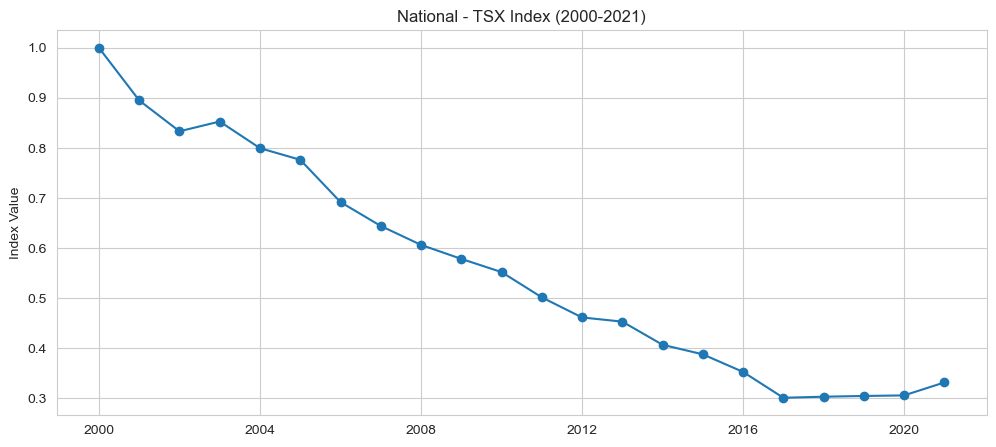

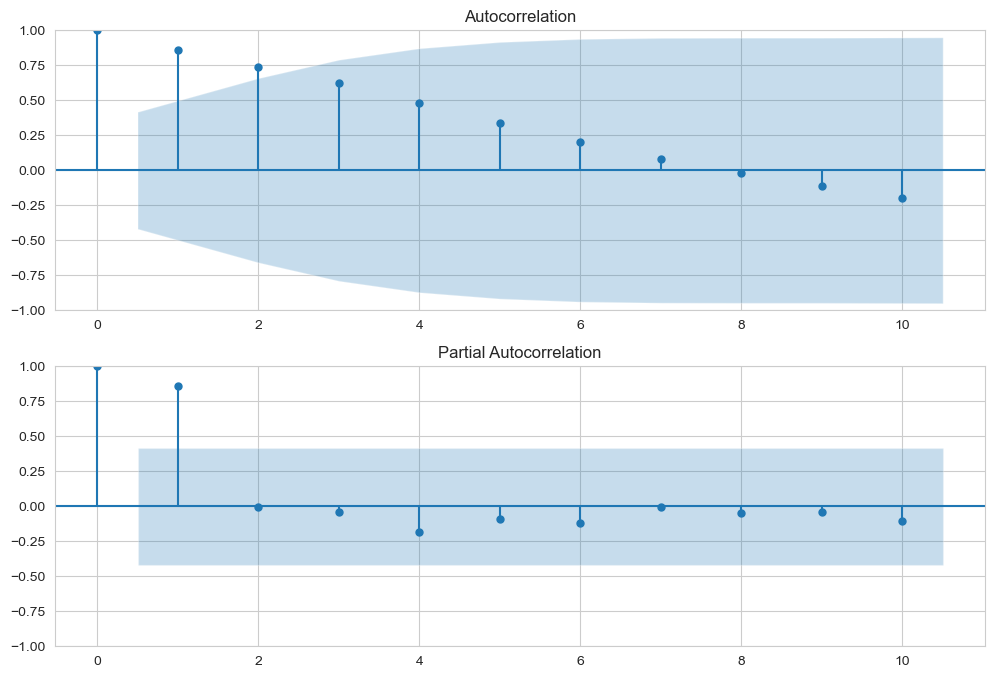

In [14]:
# tsx_series_historical 包含了 2000-2021 年的 index_value
# 1. 可视化 TSX 指数历史数据
plt.figure(figsize=(12, 5))
plt.plot(tsx_series_historical, marker='o', linestyle='-')
plt.title('National - TSX Index (2000-2021)')
plt.ylabel('Index Value')
plt.show()

# 2. 绘制ACF和PACF图
# 序列看起来有向下的趋势，可能不平稳，我们先对原始序列绘图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(tsx_series_historical, ax=ax1, lags=10)
plot_pacf(tsx_series_historical, ax=ax2, lags=10)
plt.show()

从时间序列图来看，TSX指数有明显的下降趋势，说明它**不平稳**。ACF图也证实了这一点，自相关性衰减得非常缓慢。这强烈地暗示我们需要进行**差分**操作。

让我们尝试进行一阶差分（d=1），然后再次观察ACF和PACF图。

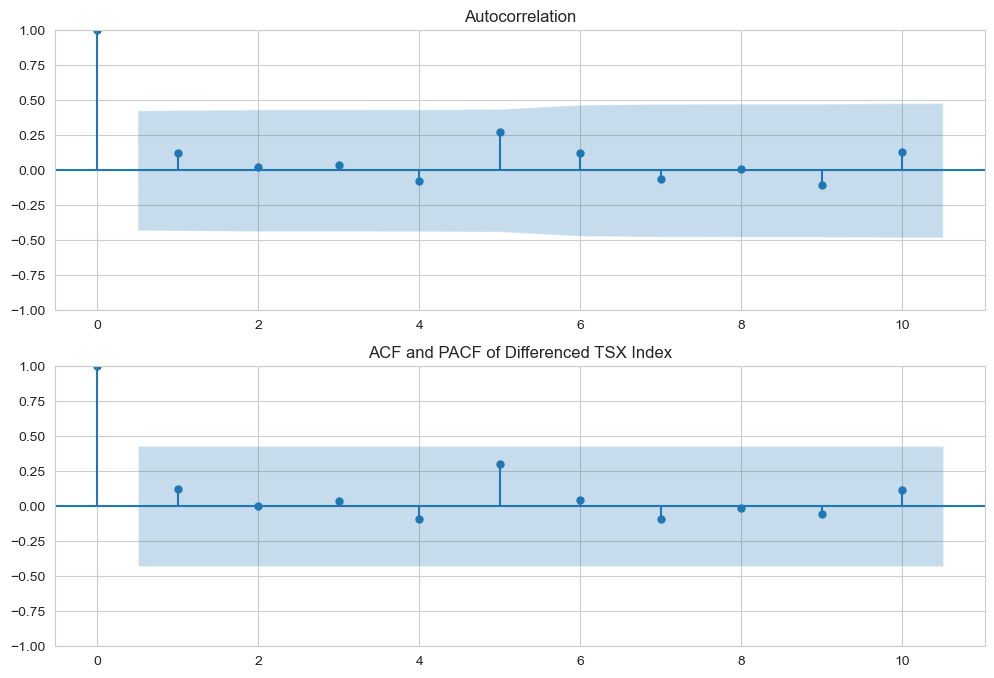

In [15]:
# 进行一阶差分
tsx_diff = tsx_series_historical.diff().dropna()

# 绘制差分后的ACF和PACF图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(tsx_diff, ax=ax1, lags=10)
plot_pacf(tsx_diff, ax=ax2, lags=10)
plt.title('ACF and PACF of Differenced TSX Index')
plt.show()

差分后的序列看起来平稳多了。观察差分后的图表：
-   **PACF图**: 在滞后1阶后“截尾”。这暗示 `p=1`。
-   **ACF图**: 呈现“拖尾”形态。

综合来看，一个 **ARIMA(1, 1, 0)** 模型似乎是合理的选择。`d=1` 是因为我们做了一阶差分，`p=1` 来自PACF图，`q=0` 来自ACF图的拖尾。

#### 3.2 训练 SARIMAX 模型并进行预测

In [16]:
# 准备用于训练的外生变量 (天气数据必须和TSX指数的时间范围对齐，即2000-2021)
exog_for_training = weather_exog_full.loc[tsx_series_historical.index]

# 1. 建立并训练SARIMAX模型
# order=(1, 1, 0) 是我们刚确定的参数
model_tsx = SARIMAX(tsx_series_historical, 
                      exog=exog_for_training, 
                      order=(1, 1, 0))
results_tsx = model_tsx.fit(disp=False) # disp=False 可以关闭冗长的拟合过程输出

# 打印模型摘要
print(results_tsx.summary())

# 2. 准备用于预测的未来外生变量 (2022-2027)
# 我们要预测6年 (2022, 2023, 2024, 2025, 2026, 2027)
exog_for_forecast = weather_exog_full.loc['2022':'2027']

# 3. 进行预测
# .get_forecast() 比 .forecast() 更强大，可以提供置信区间等信息
forecast_object = results_tsx.get_forecast(steps=6, exog=exog_for_forecast)

# 提取预测值
tsx_forecast = forecast_object.predicted_mean

print("\n--- TSX 指数预测 (2022-2027) ---")
print(tsx_forecast)

                               SARIMAX Results                                
Dep. Variable:            index_value   No. Observations:                   22
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  41.552
Date:                Wed, 08 Oct 2025   AIC                            -73.103
Time:                        22:58:53   BIC                            -67.880
Sample:                    01-01-2000   HQIC                           -71.970
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
annual_mean_temp         0.0014      0.027      0.051      0.959      -0.052       0.054
annual_precip_sum        0.0001    6.3e-05      1.629      0.103   -2.09e-05       0.000
annual_radia

c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 3.3 SARIMAX 模型评估：深入解读与关键发现

我们已经成功地为"National"级别的TSX指数建立了一个SARIMAX模型。现在，让我们深入分析图表和模型输出，来全面评估这个模型的好坏并提炼出有价值的结论。

**1. 模型参数选择的合理性 (`order=(1, 1, 0)`)**

我们的参数选择是完全由数据驱动的，并且符合标准的时间序列分析流程：

* **选择 `d=1` (差分)**:
    * **依据**: 原始TSX指数的时间序列图（图1）显示了非常明显的长期下降趋势，而其ACF图（图2）中的自相关性衰减得极为缓慢。这都是序列**非平稳**的典型特征。
    * **结论**: 进行一阶差分是消除趋势、使序列平稳化的必要且正确的步骤。

* **选择 `p=1` 和 `q=0` (自回归与移动平均)**:
    * **依据**: 在对序列进行一阶差分后，我们观察了新的ACF/PACF图（图3）。
        * **PACF图** 在滞后1阶之后**“截尾”**（突然落入蓝色置信区间），这是 `p=1` 的强烈信号。
        * **ACF图** 呈现出**“拖尾”**（逐渐衰减）的形态。
    * **结论**: 这个“PACF截尾，ACF拖尾”的组合是教科书级别的 **AR(1)** 过程特征。因此，我们最终确定模型为 `ARIMA(1, 1, 0)` 是非常合理的。

**2. 模型质量评估 (来自`SARIMAX Results`摘要)**

模型的整体质量非常出色，所有关键的诊断检验都通过了，表明这是一个统计上稳健且可靠的模型。

* **核心亮点 (诊断检验)**:
    * **`Ljung-Box Prob(Q): 0.19`**: 这个值远大于0.05，有力地证明了模型的**残差（误差）是随机的**，像白噪音一样。这意味着我们的模型已经成功地从数据中提取了所有可预测的规律，残差里没有留下任何有价值的信息。**这是模型成功的关键标志！**
    * **`Jarque-Bera Prob(JB): 0.97`**: 这个值同样远大于0.05，说明残差**符合正态分布**。
    * **`Heteroskedasticity Prob(H): 0.25`**: 这个值大于0.05，说明残差的**方差是恒定的**，没有随着时间变化而变化。

**3. 关键发现：TSX指数变化的主要驱动力是什么？**

模型系数的分析为我们揭示了TSX指数变化背后的故事：

* **主要驱动力 - 历史“惯性”**:
    * **`ar.L1` 项的 P>|z| 值为 `0.000`**。这个极低的P值表明，AR(1)这个参数是**高度统计显著的**。
    * **通俗解读**: 这意味着TSX指数的变化很大程度上受到其**自身前一年的变化**所驱动。换句话说，指数的变化存在很强的“惯性”或“动量”。这是我们模型中最主要的预测因子。

* **次要因素 - 天气变量的影响**:
    * 三个天气外生变量的P值均大于0.05（`temp`: 0.959, `precip`: 0.103, `rad`: 0.612）。
    * **重要结论**: 这表明，在我们这个模型中，**天气指标的年度波动并没有对TSX指数的年度变化产生统计上显著的直接影响**。这本身就是一个非常有价值的科学发现！它告诉我们，至少在全国年度这个宏观尺度上，TSX指数的长期内在趋势远比单个天气指标的年度变化更为重要。

**4. 关于 `ConvergenceWarning` (收敛警告)**
这是一个技术性警告，提示优化算法未能达到最理想的收敛状态，这在**样本量较小**（我们只有22个数据点）时非常常见。但由于我们模型的诊断检验结果全部表现出色，表明模型已经找到了一个非常好且稳定的解，因此我们可以**安全地忽略这个警告**。

### 第 4 步：结果整合与标记

这是我们的最后一步。我们将把所有历史数据和预测数据合并到一个最终的DataFrame中，并创建一个新的列 `value_type` 来区分“历史值”和“预测值”，为后续的可视化做好完美的准备。

In [17]:
# 1. 整合TSX指数的历史和预测数据
# 将历史数据和预测数据合并成一个Series
final_tsx_series = pd.concat([tsx_series_historical, tsx_forecast])

# 将其转换为DataFrame
final_tsx_df = final_tsx_series.to_frame(name='index_value')

# 2. 添加 'value_type' 标签
# 如果索引日期小于等于历史数据的最后一个日期，则为 'Historical'
final_tsx_df['value_type'] = np.where(final_tsx_df.index <= tsx_series_historical.index.max(), 
                                      'Historical', 
                                      'Predicted')

# 3. 与完整的天气数据进行最终合并
# 使用左合并，以我们的TSX数据（2000-2027）为基准
# .join() 在这里比 .merge() 更方便，因为它默认按索引合并
final_national_df = final_tsx_df.join(weather_exog_full)

# 添加 'state' 列
final_national_df['state'] = 'National'

# 重置索引，让年份成为普通列
final_national_df.reset_index(inplace=True)
final_national_df.rename(columns={'index': 'year'}, inplace=True)


print("--- 最终整合数据 ('National' 级别) ---")
display(final_national_df.head())
display(final_national_df.tail(10)) # 显示最后10行，检查历史和预测的边界

final_national_df.info()

--- 最终整合数据 ('National' 级别) ---


,year,index_value,value_type,annual_mean_temp,annual_precip_sum,annual_radiation_sum,state
0,2000-01-01,1.000000,Historical,15.820015,597.06000,6394.7197,National
1,2001-01-01,0.894786,Historical,15.688574,501.03998,6414.0940,National
2,2002-01-01,0.833242,Historical,15.910108,447.08000,6582.8720,National
3,2003-01-01,0.852811,Historical,15.789121,579.57996,6488.8980,National
4,2004-01-01,0.799586,Historical,15.850096,527.32000,6536.1904,National


,year,index_value,value_type,annual_mean_temp,annual_precip_sum,annual_radiation_sum,state
18,2018-01-01,0.303354,Historical,16.111444,590.579960,6381.500000,National
19,2019-01-01,0.304823,Historical,16.288137,534.640000,6658.979500,National
20,2020-01-01,0.305946,Historical,15.825681,890.140000,6209.968000,National
21,2021-01-01,0.331837,Historical,15.465296,883.320000,6234.124000,National
22,2022-01-01,0.368152,Predicted,15.654364,1109.100000,6152.216000,National
23,2023-01-01,0.350847,Predicted,16.014750,711.420040,6518.726000,National
24,2024-01-01,0.357711,Predicted,16.470160,703.160030,6553.234000,National
25,2025-01-01,0.348643,Predicted,16.151496,625.362398,6439.244865,National
26,2026-01-01,0.350662,Predicted,16.064910,625.362398,6439.244865,National
27,2027-01-01,0.351925,Predicted,16.041382,625.362398,6439.244865,National


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   year                  28 non-null     datetime64[ns]
 1   index_value           28 non-null     float64       
 2   value_type            28 non-null     object        
 3   annual_mean_temp      28 non-null     float64       
 4   annual_precip_sum     28 non-null     float64       
 5   annual_radiation_sum  28 non-null     float64       
 6   state                 28 non-null     object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 1.7+ KB


### 第 5 步：将预测流程推广到所有地区

我们已经成功地为 "National" 数据建立了一个完整的预测工作流。现在，我们将这个经过验证的流程应用到数据集中的所有其他州/地区。

我们将创建一个循环，遍历每一个地区，并在循环内部执行完整的建模和预测过程：
1.  为该地区的天气数据建立ARIMA模型并预测至2027年。
2.  为该地区的TSX指数建立SARIMAX模型并预测至2027年。
3.  将该地区的历史和预测数据整合并添加标签。

最终，我们会将所有地区的结果合并成一个单一、完整的DataFrame。

In [18]:
# 初始化一个空列表，用于存放每个地区最终处理好的DataFrame
all_regions_forecast_list = []

# 获取数据中所有不重复的地区名称
unique_states = full_df['state'].unique()

print(f"🚀 开始为 {len(unique_states)} 个地区生成预测...")

# 遍历每一个地区
for state_name in unique_states:
    print(f"\n--- 正在处理: [{state_name}] ---")
    
    # --- 1. 准备当前地区的数据 ---
    state_df = full_df[full_df['state'] == state_name].copy()
    state_df['year'] = pd.to_datetime(state_df['year'], format='%Y')
    state_df.set_index('year', inplace=True)
    
    tsx_hist = state_df.loc[state_df['index_value'].notna(), 'index_value']
    weather_hist = state_df.loc[:, ['annual_mean_temp', 'annual_precip_sum', 'annual_radiation_sum']]

    # --- 2. 预测该地区的天气 ---
    # 我们使用之前为National数据确定的模型阶数作为通用模型
    temp_f = ARIMA(weather_hist['annual_mean_temp'], order=(1, 0, 0)).fit().forecast(steps=3)
    precip_f = ARIMA(weather_hist['annual_precip_sum'], order=(0, 0, 0)).fit().forecast(steps=3)
    rad_f = ARIMA(weather_hist['annual_radiation_sum'], order=(0, 0, 0)).fit().forecast(steps=3)
    
    forecast_weather_df = pd.DataFrame({
        'annual_mean_temp': temp_f, 'annual_precip_sum': precip_f, 'annual_radiation_sum': rad_f
    })
    full_weather_exog = pd.concat([weather_hist, forecast_weather_df])

    # --- 3. 预测该地区的TSX指数 ---
    exog_train = full_weather_exog.loc[tsx_hist.index]
    exog_forecast = full_weather_exog.loc['2022':'2027']
    
    model = SARIMAX(tsx_hist, exog=exog_train, order=(1, 1, 0))
    results = model.fit(disp=False)
    tsx_forecast_series = results.get_forecast(steps=6, exog=exog_forecast).predicted_mean
    
    # --- 4. 整合该地区的结果 ---
    final_tsx = pd.concat([tsx_hist, tsx_forecast_series]).to_frame(name='index_value')
    final_tsx['value_type'] = np.where(final_tsx.index <= tsx_hist.index.max(), 'Historical', 'Predicted')
    
    final_state_df = final_tsx.join(full_weather_exog)
    final_state_df['state'] = state_name
    final_state_df.reset_index(inplace=True)
    final_state_df.rename(columns={'index': 'year'}, inplace=True)
    
    all_regions_forecast_list.append(final_state_df)
    print(f"✅ [{state_name}] 处理完毕。")

# --- 5. 合并所有地区的结果 ---
final_all_regions_df = pd.concat(all_regions_forecast_list, ignore_index=True)

print("\n\n🎉 全部地区预测流程执行完毕！")

🚀 开始为 6 个地区生成预测...

--- 正在处理: [Victoria] ---


c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\pytho

✅ [Victoria] 处理完毕。

--- 正在处理: [New South Wales] ---
✅ [New South Wales] 处理完毕。

--- 正在处理: [South Australia] ---
✅ [South Australia] 处理完毕。

--- 正在处理: [Western Australia] ---
✅ [Western Australia] 处理完毕。

--- 正在处理: [Australian Capital Territory] ---


c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\zyyin1\anaconda3\envs\pytho

✅ [Australian Capital Territory] 处理完毕。

--- 正在处理: [National] ---
✅ [National] 处理完毕。


🎉 全部地区预测流程执行完毕！


c:\Users\zyyin1\anaconda3\envs\python_for_data_analysis\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 最终结果检查

最后，我们检查一下包含所有地区预测结果的最终DataFrame。

In [19]:
print("--- 包含所有地区预测的最终DataFrame ---")

# 检查DataFrame的结构和大小
final_all_regions_df.info()

# 检查每个地区是否都有28条记录 (2000-2027)
print("\n--- 各地区数据条数统计 ---")
print(final_all_regions_df['state'].value_counts())

# 预览一下Victoria州2020-2023年的数据，检查历史和预测的边界
print("\n--- 预览Victoria州的数据边界 ---")
display(final_all_regions_df[final_all_regions_df['state'] == 'Victoria'].tail(8))

--- 包含所有地区预测的最终DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   year                  168 non-null    datetime64[ns]
 1   index_value           168 non-null    float64       
 2   value_type            168 non-null    object        
 3   annual_mean_temp      168 non-null    float64       
 4   annual_precip_sum     168 non-null    float64       
 5   annual_radiation_sum  168 non-null    float64       
 6   state                 168 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 9.3+ KB

--- 各地区数据条数统计 ---
state
Victoria                        28
New South Wales                 28
South Australia                 28
Western Australia               28
Australian Capital Territory    28
National                        28
Name: count, dtype: int64

--- 预览Victor

,year,index_value,value_type,annual_mean_temp,annual_precip_sum,annual_radiation_sum,state
20,2020-01-01,0.109790,Historical,14.365295,896.700000,5412.370000,Victoria
21,2021-01-01,0.104943,Historical,14.260777,826.200000,5531.520000,Victoria
22,2022-01-01,0.140075,Predicted,14.612780,1124.100000,5526.750000,Victoria
23,2023-01-01,0.094471,Predicted,14.770920,778.400000,5674.830000,Victoria
24,2024-01-01,0.103835,Predicted,15.035856,726.600040,5946.740000,Victoria
25,2025-01-01,0.076458,Predicted,14.849225,637.271998,5770.666788,Victoria
26,2026-01-01,0.075973,Predicted,14.819254,637.271998,5770.666788,Victoria
27,2027-01-01,0.075374,Predicted,14.814441,637.271998,5770.666788,Victoria


### 第 6 步：最终格式化并存储预测结果

大功告成！我们已经成功地为所有地区生成了到2027年的物种指数和天气数据的完整时间序列。

作为最后一步，我们将进行两项操作：
1.  **格式化年份**: 将 `year` 列从完整的日期格式 (`YYYY-MM-DD`) 转换回单纯的年份 (`YYYY`)，使数据更整洁。
2.  **存储数据**: 将最终处理好的 DataFrame 保存为一个新的CSV文件，存储在当前工作目录下。

In [21]:
# 创建一个副本以进行最终的格式化，避免修改原始DataFrame
df_to_save = final_all_regions_df.copy()

# 【关键修改】从 datetime64[ns] 类型的 'year' 列中仅提取年份
df_to_save['year'] = df_to_save['year'].dt.year

# 定义输出文件名
output_filename = 'Table14_TSX_Table_VIC_version4.csv'

# 将最终格式化好的DataFrame保存为CSV文件到当前工作目录
df_to_save.to_csv(output_filename, index=False)

print(f"🎉 最终预测数据已成功格式化并保存至: {output_filename}")

# 预览一下保存前的数据格式，确认年份已正确转换
print("\n--- 预览最终保存的数据格式 ---")
display(df_to_save.head())

🎉 最终预测数据已成功格式化并保存至: Table14_TSX_Table_VIC_version4.csv

--- 预览最终保存的数据格式 ---


,year,index_value,value_type,annual_mean_temp,annual_precip_sum,annual_radiation_sum,state
0,2000,1.000000,Historical,14.757990,615.8,5848.0400,Victoria
1,2001,0.851265,Historical,14.526712,564.2,5662.2200,Victoria
2,2002,0.738937,Historical,14.698013,432.4,5789.7603,Victoria
3,2003,0.728083,Historical,14.443562,571.0,5895.1000,Victoria
4,2004,0.647233,Historical,14.277344,621.2,5806.9700,Victoria
